In [5]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import os
import torch
from torchvision import transforms
import albumentations as A
import cv2
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from minisom import MiniSom
import matplotlib.pyplot as plt





/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models


In [9]:
from torchvision import models


In [5]:

img_size = (224, 224)
root_dir = 'FLIR_ADAS_1_3/train'
subfolders = ['Annotated_thermal_8_bit','RGB', 'thermal_16_bit']
all_images = []
all_labels = []

In [ ]:
def load_images_from_subfolders(subfolders, root_dir, img_size):
    for subfolder in subfolders:
        subfolder_path = os.path.join(root_dir, subfolder)

        if os.path.isdir(subfolder_path):
            print(f"Processing folder: {subfolder_path}")
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(subfolder_path, filename)

                    try:
                        img = Image.open(img_path).convert('RGB')

                        img = img.resize(img_size)
                        img_array = np.array(img)

                        all_images.append(img_array)


                        label = subfolder
                        all_labels.append(label)

                    except Exception as e:
                        print(f"Error loading image {filename}: {e}")
        else:
            print(f"Subfolder {subfolder} does not exist in the directory {root_dir}")

In [ ]:
load_images_from_subfolders(subfolders, root_dir, (224,224))

Processing folder: archive/FLIR_ADAS_1_3/train\Annotated_thermal_8_bit
Processing folder: archive/FLIR_ADAS_1_3/train\RGB


In [ ]:
X = np.array(all_images)
y = np.array(all_labels)

print(f"Shape of image data: {X.shape}")
print(f"Shape of labels: {y.shape}")




Shape of image data: (17225, 224, 224, 3)
Shape of labels: (17225,)


In [ ]:
X = X/255.0


In [ ]:
np.save('processed_image_data1.npy', y)


In [7]:
X= np.load('processed_image_datas.npy')
X



array(['Annotated_thermal_8_bit', 'Annotated_thermal_8_bit',
       'Annotated_thermal_8_bit', ..., 'RGB', 'RGB', 'RGB'], dtype='<U23')

In [ ]:
y= np.load('processed_image_data1.npy')


In [ ]:
X.shape

(17225, 224, 224, 3)

In [10]:
model = models.regnet_y_800mf(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_800MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_800MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-1b27b58c.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-1b27b58c.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 92.5MB/s]


In [11]:
model.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [ ]:
def extract_features(model, dataloader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)

            output = model.forward_features(inputs)

            output = output.view(output.size(0), -1)

            features.append(output.cpu().numpy())
            labels.append(label)

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels


In [ ]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = np.array(img).astype(np.uint8)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)

        return img, label

In [ ]:
y_tensor = torch.tensor(y_encoded)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = ImageDataset(X, y_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [ ]:
model = torch.nn.Sequential(*list(model.children())[:-1])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [ ]:
def extract_features(model, dataloader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)

            output = model(inputs)

            output = output.view(output.size(0), -1)

            features.append(output.cpu().numpy())
            labels.append(label)

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [ ]:
features, labels = extract_features(model, dataloader)

print(f"Shape of extracted features: {features.shape}")
print(f"Shape of labels: {labels.shape}")

In [ ]:
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)



In [ ]:
features = features.reshape((13325, 2048))
features.shape


In [ ]:
def build_autoencoder(input_dim, encoding_dim):

    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(512, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    decoded = layers.Dense(512, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(input_layer, decoded)

    encoder = models.Model(input_layer, encoded)

    encoded_input = layers.Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-2](encoded_input)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    decoder = models.Model(encoded_input, decoder_layer)

    return autoencoder, encoder, decoder

In [ ]:
input_dim = features.shape[1]
encoding_dim = 128

autoencoder, encoder, decoder = build_autoencoder(input_dim, encoding_dim)

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(features, features, epochs=50, batch_size=256, shuffle=True, validation_split=0.1)


In [ ]:
encoded_features = encoder.predict(features)

print(encoded_features.shape)

In [ ]:
encoded_features[0]
with open('encoded_features.pkl', 'wb') as f:
    pickle.dump(encoded_features, f)

print("Pickle file created successfully.")

In [ ]:
################################# done with the autoencoder ####################################################


In [ ]:
################################# Now next step is : Self-Organizing Map (SOM) , use to make cluster of similar and neighbouring places #######


In [6]:
with open('encoded_features.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

print("Pickled array loaded:", loaded_array.shape)

Pickled array loaded: (13325, 128)


In [23]:
loaded_array.ndim

2

In [8]:
#coding starts from working of SOM
som_grid_x = 150
som_grid_y = 150
sigma = 0.5
learning_rate = 0.5
num_iterations = 25000


In [9]:
som = MiniSom(x=som_grid_x, y=som_grid_y, input_len=loaded_array.shape[1],
              sigma=sigma, learning_rate=learning_rate)
som.random_weights_init(loaded_array)

In [10]:
# here i will do the training for SOM
print("Training SOM...")
som.train_random(data=loaded_array, num_iteration=num_iterations)
print("SOM Training Complete.")

Training SOM...
SOM Training Complete.


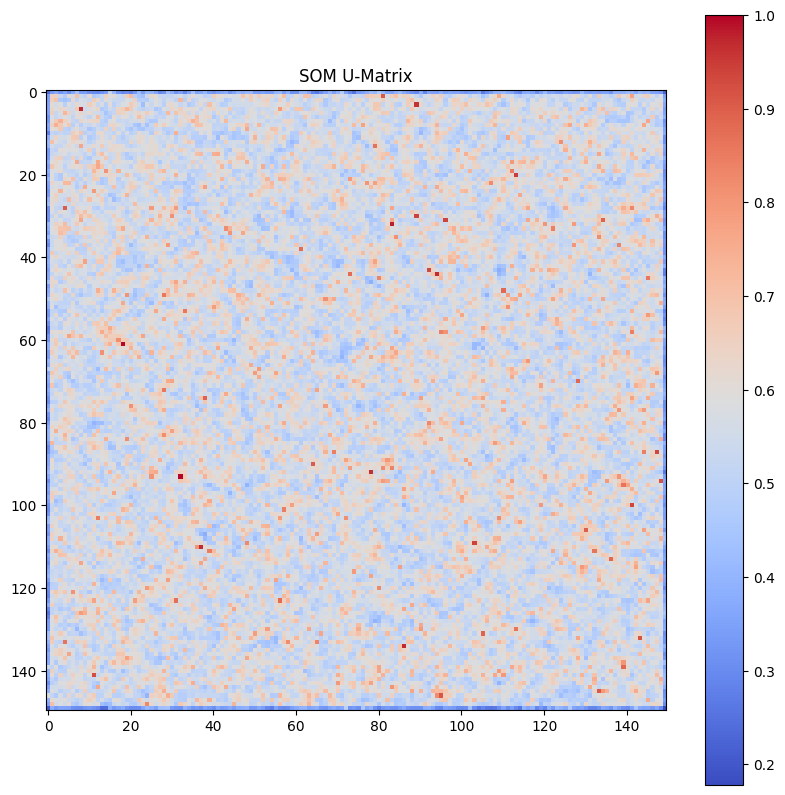

In [11]:
u_matrix = som.distance_map()
plt.figure(figsize=(10, 10))
plt.title("SOM U-Matrix")
plt.imshow(u_matrix, cmap='coolwarm')
plt.colorbar()
plt.show()

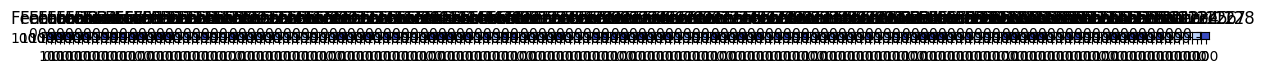

In [18]:
num_features = som.get_weights().shape[2]

fig, axes = plt.subplots(1, num_features, figsize=(15, 5))
for i in range(num_features):
    axes[i].imshow(som.get_weights()[:, :, i], cmap='coolwarm')
    axes[i].set_title(f'Feature {i+1}')
plt.show()

In [28]:
import networkx as nx
G = nx.Graph()

for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        G.add_node((x, y))
for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        if x > 0:
            G.add_edge((x, y), (x-1, y))
        if y > 0:
            G.add_edge((x, y), (x, y-1))
        if x < som.get_weights().shape[0] - 1:
            G.add_edge((x, y), (x+1, y))
        if y < som.get_weights().shape[1] - 1:
            G.add_edge((x, y), (x, y+1))

In [29]:
test_input = loaded_array[8].flatten()
winner_node = som.winner(test_input)
print(f"Winner node for the test input: {winner_node}")


Winner node for the test input: (92, 5)


In [30]:
neighbors = list(G.neighbors(winner_node))
print(f"Neighbors of winner node {winner_node}: {neighbors}")

Neighbors of winner node (92, 5): [(91, 5), (92, 4), (93, 5), (92, 6)]


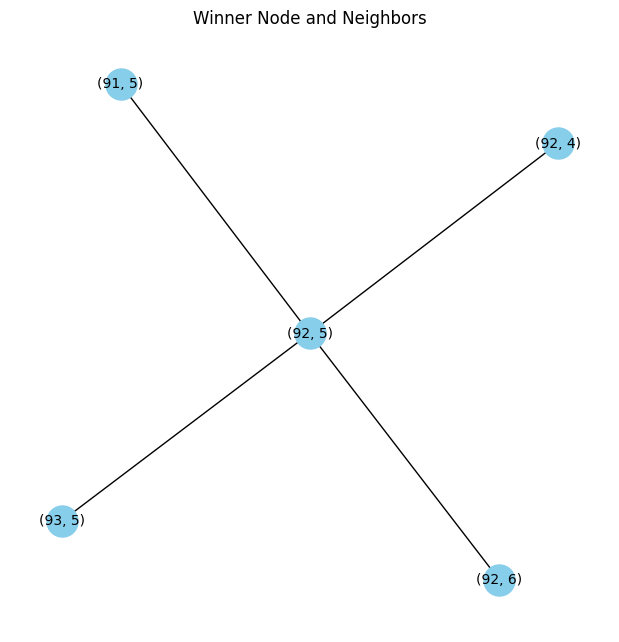

In [33]:
subgraph_nodes = [winner_node] + neighbors
H = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(6, 6))
nx.draw(H, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
plt.title("Winner Node and Neighbors")
plt.show()

In [52]:
test_input = loaded_array[2].flatten()
winner_node = som.winner(test_input)
print(f"Winner node for the test input: {winner_node}")


Winner node for the test input: (20, 138)


In [53]:
neighbors = list(G.neighbors(winner_node))
print(f"Neighbors of winner node {winner_node}: {neighbors}")

Neighbors of winner node (20, 138): [(19, 138), (20, 137), (21, 138), (20, 139)]


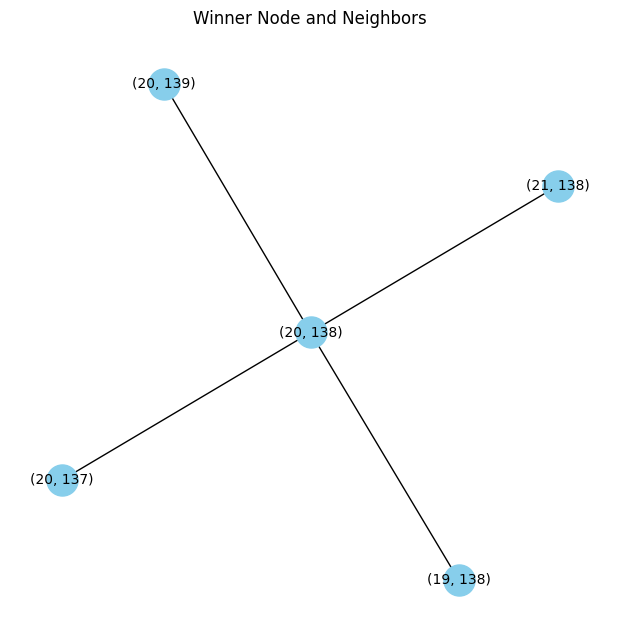

In [54]:
subgraph_nodes = [winner_node] + neighbors
H = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(6, 6))
nx.draw(H, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
plt.title("Winner Node and Neighbors")
plt.show()

In [56]:
test_input = loaded_array[45].flatten()
winner_node = som.winner(test_input)
print(f"Winner node for the test input: {winner_node}")


Winner node for the test input: (99, 125)


In [57]:
neighbors = list(G.neighbors(winner_node))
print(f"Neighbors of winner node {winner_node}: {neighbors}")

Neighbors of winner node (99, 125): [(98, 125), (99, 124), (100, 125), (99, 126)]


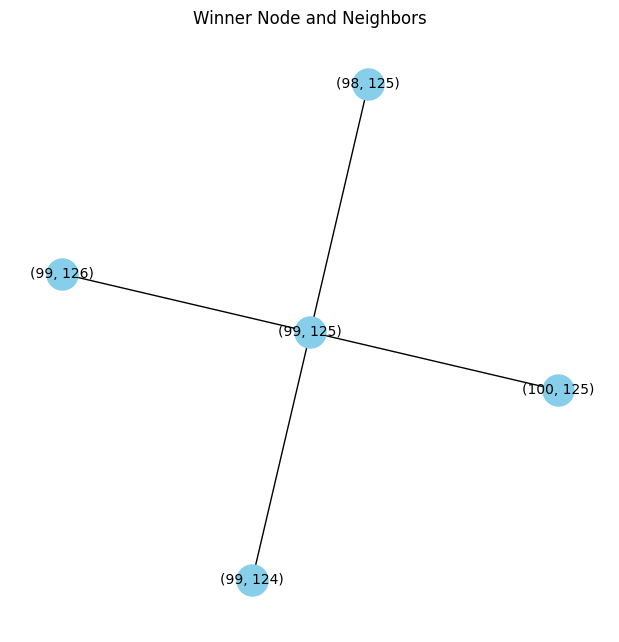

In [58]:
subgraph_nodes = [winner_node] + neighbors
H = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(6, 6))
nx.draw(H, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
plt.title("Winner Node and Neighbors")
plt.show()

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

winning_nodes = np.array([som.winner(x) for x in loaded_array])



In [43]:
winning_nodes.shape

(13325, 2)

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


kmeans = KMeans(n_clusters=50)
kmeans.fit(loaded_array)

kmeans_labels = kmeans.labels_

silhouette_avg_kmeans = silhouette_score(loaded_array, kmeans_labels)
print(f"Silhouette Score for K-Means: {silhouette_avg_kmeans}")

Silhouette Score for K-Means: 0.0492166243493557


In [51]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(loaded_array, kmeans_labels)
print(f"Error rate is: {db_index:.2f}")

Davies-Bouldin Index: 2.91


In [ ]:
image_labels = []
for feature in loaded_array:
    winner_node = som.winner(feature)
    image_labels.append(winner_node)


In [ ]:
image_labels = np.array(image_labels)
print(f"Image labels assigned to SOM nodes: {image_labels.shape}")

In [ ]:
quantization_error = som.quantization_error(loaded_array)
print(f"Quantization Error: {quantization_error:.4f}")

In [ ]:
with open('After_SOM_Data.pkl', 'wb') as m:
    loaded_array1 = pickle.dump(image_labels,m)

In [ ]:
image_labels

In [ ]:
image_labels.shape

In [ ]:
import pickle
with open('After_SOM_Data.pkl', 'rb') as m:
    loaded_array2 = pickle.load(m)

In [ ]:
loaded_array2.shape

(406, 2)

In [ ]:
################################### Now next step is working on inserting new image and by extracting feature from image , preprocess it,
################################### then main thing finding the best matching unit and apply localization

In [ ]:
loaded_array2


array([[118, 115],
       [ 23,   1],
       [102, 122],
       [ 36,  63],
       [  6,  76],
       [102, 129],
       [117, 109],
       [ 40,  64],
       [ 69, 142],
       [115,  26],
       [ 94, 143],
       [112, 133],
       [ 75, 109],
       [142, 106],
       [ 56, 106],
       [ 41,  39],
       [111,  69],
       [ 16, 144],
       [ 51, 112],
       [ 33,  86],
       [103,  32],
       [ 78,   4],
       [ 39, 124],
       [  1, 124],
       [ 40,  92],
       [ 89, 122],
       [125,  32],
       [ 76,  61],
       [ 67,  45],
       [ 20,  20],
       [139,   8],
       [ 57,  56],
       [132, 125],
       [ 72, 122],
       [ 29,  32],
       [127,  55],
       [  3,  91],
       [ 24, 144],
       [ 35,  82],
       [ 26,  31],
       [ 71,  38],
       [125, 145],
       [ 94,  50],
       [120,  46],
       [ 15, 118],
       [ 11, 143],
       [ 71,  80],
       [104,  65],
       [ 28, 143],
       [ 56, 106],
       [ 65,  11],
       [ 17,  33],
       [ 15,

In [ ]:
################################### Putting all images in a doctionary and then giving names to them like place 1 and so on

x = 150
y = 150


In [ ]:
def generate_sequential_locations(x, y):
    locations = {}
    place_number = 1

    for x in range(x):
        for y in range(y):
            locations[(x, y)] = f"Place {place_number}"
            place_number += 1

    return locations

In [ ]:
locations = generate_sequential_locations(x, y)

In [ ]:
locations[(2,3)]

'Place 303'

In [ ]:
mapped_locations = {}
place_number = 1
for coord in loaded_array2:
    x, y = coord
    if (x, y) in locations:
        mapped_locations[(x, y)] = f"Place {place_number}"
        place_number = place_number+1

    else:
        mapped_locations["Unknown"] = f"Place {place_number}"

        place_number = place_number+1



In [ ]:

for key in list(mapped_locations.keys()):
    if "Unknown" in key:
        del mapped_locations[key]

In [ ]:
mapped_locations

{(np.int64(23), np.int64(1)): 'Place 2',
 (np.int64(36), np.int64(63)): 'Place 123',
 (np.int64(6), np.int64(76)): 'Place 5',
 (np.int64(40), np.int64(64)): 'Place 8',
 (np.int64(115), np.int64(26)): 'Place 10',
 (np.int64(41), np.int64(39)): 'Place 16',
 (np.int64(33), np.int64(86)): 'Place 20',
 (np.int64(103), np.int64(32)): 'Place 21',
 (np.int64(78), np.int64(4)): 'Place 22',
 (np.int64(1), np.int64(124)): 'Place 24',
 (np.int64(40), np.int64(92)): 'Place 25',
 (np.int64(76), np.int64(61)): 'Place 28',
 (np.int64(67), np.int64(45)): 'Place 29',
 (np.int64(20), np.int64(20)): 'Place 30',
 (np.int64(139), np.int64(8)): 'Place 31',
 (np.int64(57), np.int64(56)): 'Place 32',
 (np.int64(29), np.int64(32)): 'Place 35',
 (np.int64(3), np.int64(91)): 'Place 37',
 (np.int64(35), np.int64(82)): 'Place 39',
 (np.int64(26), np.int64(31)): 'Place 40',
 (np.int64(71), np.int64(38)): 'Place 41',
 (np.int64(94), np.int64(50)): 'Place 43',
 (np.int64(15), np.int64(118)): 'Place 45',
 (np.int64(65)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
########################################### testing starts here in testing file #######################################################
